In [12]:
import os
import random
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import mmcv
from mmcv import Config
from mmdet.datasets.utils import get_dataset


image_dir = 'data/dataset/images'
filenames = os.listdir(image_dir)

cfg = Config.fromfile('configs/baseline.py')
ds = get_dataset(cfg.data.train)

In [8]:
img, ann, img_info = ds._get_img_ann(0)
data1 = ds._get_img_ann(0)
data2 = ds._get_img_ann(1)

In [4]:
img.shape

(391, 680, 3)

In [6]:
img_info

{'coco_url': '',
 'data_captured': '',
 'file_name': '190119_184244_00166940.jpg',
 'flickr_url': '',
 'id': 0,
 'height': 391,
 'width': 680,
 'license': 1,
 'filename': '190119_184244_00166940.jpg'}

In [5]:
ann

{'bboxes': array([[ 88., 253., 205., 294.],
        [296., 244., 413., 343.],
        [231., 239., 298., 340.],
        [ 99., 278., 193., 319.]], dtype=float32),
 'labels': array([3, 5, 5, 4]),
 'bboxes_ignore': array([], shape=(0, 4), dtype=float32)}

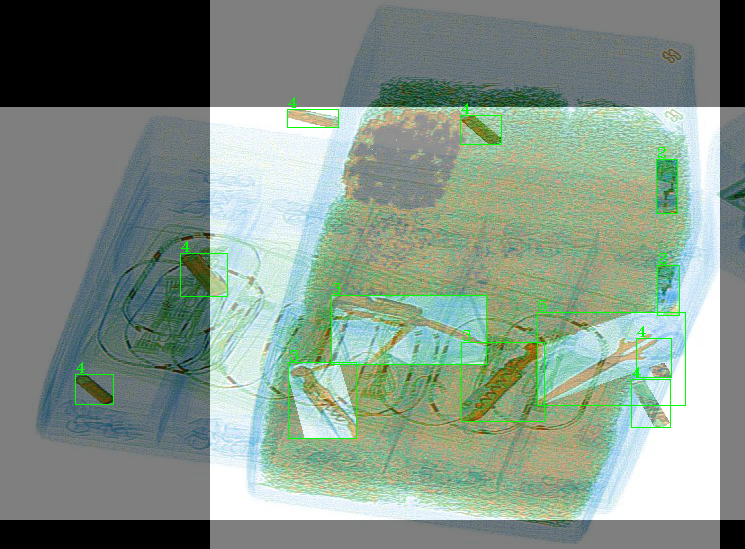

In [121]:
def _random_location(img_w, img_h, bbox_w, bbox_h):
    x = random.randint(0, img_w-bbox_w)
    y = random.randint(0, img_h-bbox_h)
    return x, y


def _mix_img_and_img_info(img1, img2, img_info1, img_info2, lam):
    """
    Args:
        img1, img2(numpy.ndarray) (h, w, c)
    """
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    h = max(h1, h2)
    w = max(w1, w2)

    mixed_img = np.zeros((h, w, img1.shape[2]))
    
    shift_x1, shift_y1 = _random_location(w, h, w1, h1)
    mixed_img[shift_y1:shift_y1+h1, shift_x1:shift_x1+w1, ...] = lam * img1
    
    shift_x2, shift_y2 = _random_location(w, h, w2, h2)
    mixed_img[shift_y2:shift_y2+h2, shift_x2:shift_x2+w2, ...] += (1-lam) * img2
    
    mixed_img_info = img_info1.copy()
    mixed_img_info['height'] = h
    mixed_img_info['width'] = w
    
    return mixed_img.astype('uint8'), mixed_img_info, (shift_x1, shift_y1, shift_x2, shift_y2)
    
    
def _mix_ann(ann1, ann2, shift):
    shift_x1, shift_y1, shift_x2, shift_y2 = shift
    
    bboxes1 = ann1['bboxes']
    bboxes1[:, 0] += shift_x1
    bboxes1[:, 1] += shift_y1
    bboxes1[:, 2] += shift_x1
    bboxes1[:, 3] += shift_y1
    
    bboxes2 = ann2['bboxes']
    bboxes2[:, 0] += shift_x2
    bboxes2[:, 1] += shift_y2
    bboxes2[:, 2] += shift_x2
    bboxes2[:, 3] += shift_y2
    mixed_bboxes = np.concatenate([bboxes1, bboxes2])
    
    labels1 = ann1['labels']
    labels2 = ann2['labels']
    mixed_labels = np.concatenate([labels1, labels2])
    
    if 'bboxes_ignore' in ann1:
        bboxes_ignore1 = ann1['bboxes_ignore']
        bboxes_ignore2 = ann2['bboxes_ignore']
        mixed_bboxes_ignore = np.concatenate([bboxes_ignore1, bboxes_ignore2])

        mixed_ann = dict(bboxes=mixed_bboxes, labels=mixed_labels, bboxes_ignore=mixed_bboxes_ignore)
    else:
        mixed_ann = dict(bboxes=mixed_bboxes, labels=mixed_labels)
    return mixed_ann
    

def mixup_data(data1, data2, prob=0):
    """
    Args:
        data1, data2 (tuple): (img, ann, img_info)
        prob(float) 0<=prob<1, mixup probability
    """
    if random.random()>=prob:
        return data1
    
    img1, ann1, img_info1 = data1
    img2, ann2, img_info2 = data2
    
    lam = 0.5
    
    mixed_img, mixed_img_info, shift = _mix_img_and_img_info(img1, img2, img_info1, img_info2, lam)
    mixed_ann = _mix_ann(ann1, ann2, shift)
    return mixed_img, mixed_ann, img_info1
    


data1 = ds._get_img_ann(random.randint(0, len(ds)-1))
data2 = ds._get_img_ann(random.randint(0, len(ds)-1))
    
mixed_img, mixed_ann, mixed_img_info = mixup_data(data1, data2, prob=0.5)
mmcv.imshow_det_bboxes(Image.fromarray(mixed_img), mixed_ann['bboxes'], mixed_ann['labels'])